In [1]:
from splink.duckdb.duckdb_linker import DuckDBLinker
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Linking banking transactions

This example shows how to perform a one-to-one link on banking transactions.  The data has the following features:

- Money shows up in the destination account with some time delay
- The amount sent and the amount received are not always the same - there are hidden fees and foreign exchange effects
- The memo is sometimes truncated and content is sometimes missing

Since each origin payment should end up in the destination account, the `probability_two_random_records_match` of the model is known.

In [2]:
# Use arrow to read in data to ensure date types are correct
from pyarrow import parquet as pq
df_origin = pq.read_table("./data/transactions_left.parquet")
df_origin = df_origin.slice(length=1_000)
df_destination = pq.read_table("./data/transactions_right.parquet")
df_destination = df_destination.slice(length=1_000)
f"There are {df_origin.num_rows:,.0f} records to match"

'There are 1,000 records to match'

In [3]:
# Some sample records
df_origin.to_pandas().head(2)

,ground_truth,memo,transaction_date,amount,unique_id
0,0,MATTHIAS C paym,2022-03-28,36.36,0
1,1,M CORVINUS dona,2022-02-14,221.91,1


In the following chart, we can see this is a challenging dataset to link:
- There are only 151 distinct transaction dates, with strong skew
- Some 'memos' are used multiple times (up to 48 times)
- There is strong skew in the 'amount' column, with 1,400 transactions of around 60.00

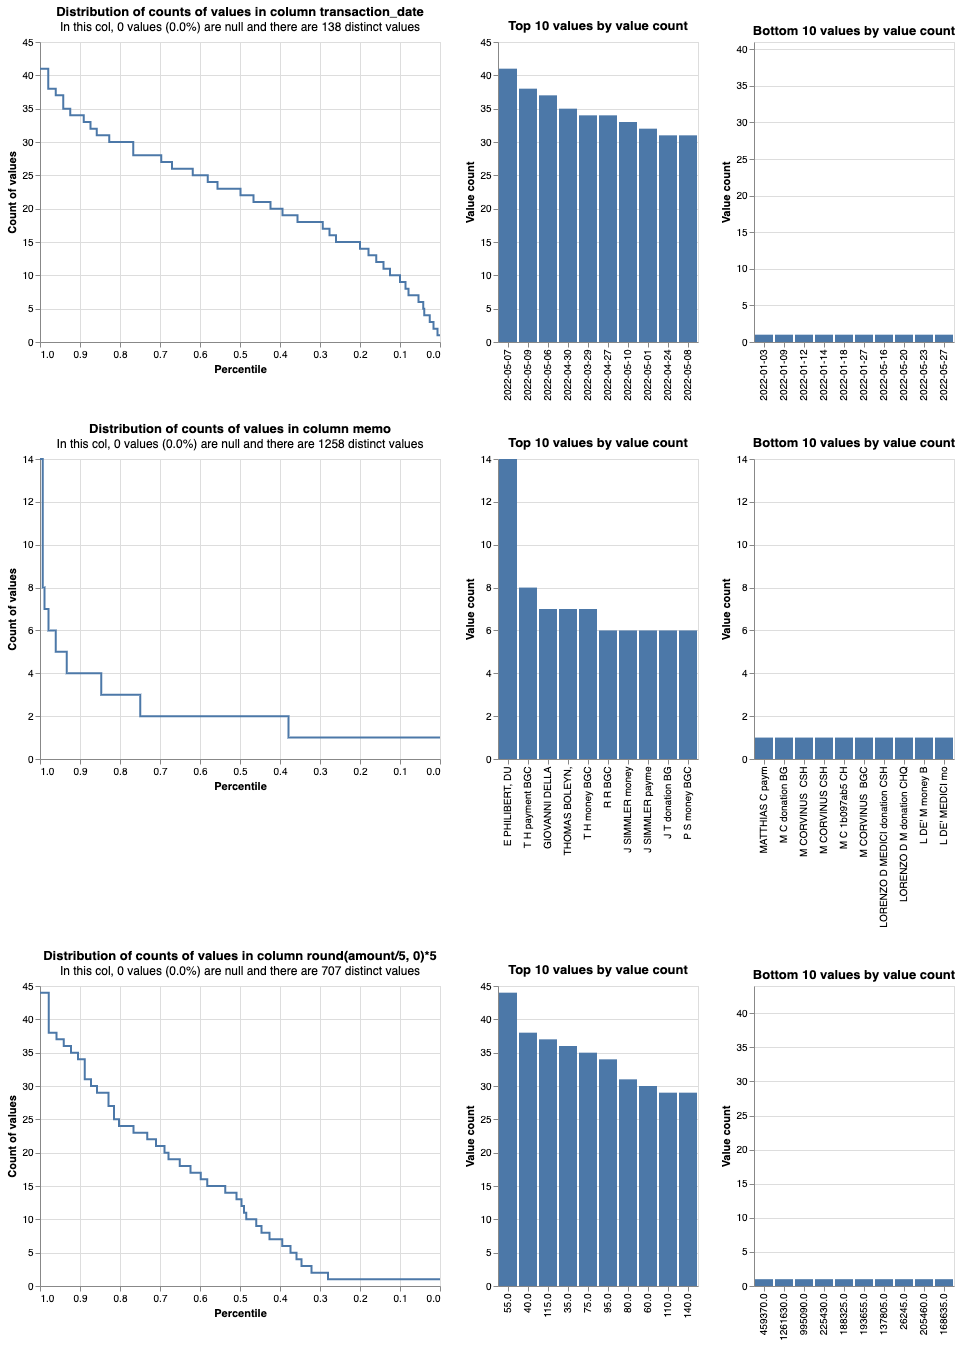

In [4]:
settings = {"link_type": "link_only"}
linker = DuckDBLinker([df_origin, df_destination], settings,input_table_aliases=["__ori", "_dest"])
linker.profile_columns(["transaction_date", "memo", "round(amount/5, 0)*5"])

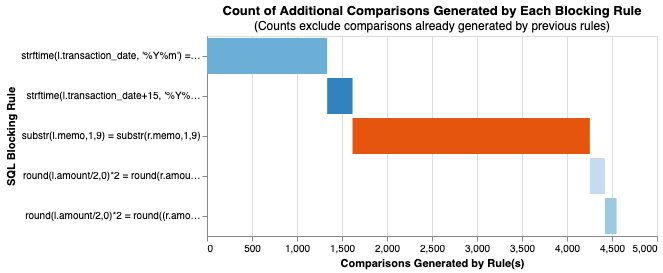

In [5]:
# Design blocking rules that allow for differences in transaction date and amounts

blocking_rule_date_1 = """
    strftime(l.transaction_date, '%Y%m') = strftime(r.transaction_date, '%Y%m')
    and substr(l.memo, 1,3) = substr(r.memo,1,3)
    and l.amount/r.amount > 0.7   and l.amount/r.amount < 1.3
"""

# Offset by half a month to ensure we capture case when the dates are e.g. 31st Jan and 1st Feb
blocking_rule_date_2 = """
    strftime(l.transaction_date+15, '%Y%m') = strftime(r.transaction_date, '%Y%m')
    and substr(l.memo, 1,3) = substr(r.memo,1,3)
    and l.amount/r.amount > 0.7   and l.amount/r.amount < 1.3
"""

blocking_rule_memo = """
substr(l.memo,1,9) = substr(r.memo,1,9)
"""

blocking_rule_amount_1 = """
round(l.amount/2,0)*2 = round(r.amount/2,0)*2 and yearweek(r.transaction_date) = yearweek(l.transaction_date)
"""

blocking_rule_amount_2 = """
round(l.amount/2,0)*2 = round((r.amount+1)/2,0)*2 and yearweek(r.transaction_date) = yearweek(l.transaction_date + 4)
"""

blocking_rule_cheat = """
l.unique_id = r.unique_id
"""


linker.cumulative_num_comparisons_from_blocking_rules_chart(
    [
        blocking_rule_date_1,
        blocking_rule_date_2,
        blocking_rule_memo,
        blocking_rule_amount_1,
        blocking_rule_amount_2,
        blocking_rule_cheat,
    ]
)

In [6]:
import splink.duckdb.duckdb_comparison_level_library as cl

comparison_amount = {
    "output_column_name": "amount",
    "comparison_levels": [
        cl.null_level("amount"),
        cl.exact_match_level("amount"),
        cl.percentage_difference_level("amount",0.01),
        cl.percentage_difference_level("amount",0.03),
        cl.percentage_difference_level("amount",0.1),
        cl.percentage_difference_level("amount",0.3),
        cl.else_level()
    ],
    "comparison_description": "Amount percentage difference",
}

within_n_days_template = "transaction_date_r - transaction_date_l <= {n} and transaction_date_r >= transaction_date_l"

comparison_date = {
    "output_column_name": "transaction_date",
    "comparison_levels": [
        cl.null_level("transaction_date"),
        {"sql_condition": within_n_days_template.format(n=1), "label_for_charts": "1 day"},
        {"sql_condition": within_n_days_template.format(n=4), "label_for_charts": "<=4 days"},
        {"sql_condition": within_n_days_template.format(n=10), "label_for_charts": "<=10 days"},
        {"sql_condition": within_n_days_template.format(n=30), "label_for_charts": "<=30 days"},
        cl.else_level()
    ],
    "comparison_description": "Transaction date days apart",
}



from splink.duckdb import duckdb_comparison_library as cl

settings = {
    "link_type": "link_only",
    "probability_two_random_records_match": 1 / len(df_origin),
    "blocking_rules_to_generate_predictions": [
        blocking_rule_date_1,
        blocking_rule_date_2,
        blocking_rule_memo,
        blocking_rule_amount_1,
        blocking_rule_amount_2,
        blocking_rule_cheat
    ],
    "comparisons": [
        comparison_amount,
        cl.jaccard_at_thresholds(
            "memo", [0.9, 0.7]
        ),
        comparison_date
    ],
    "retain_intermediate_calculation_columns": True,
    "retain_matching_columns": True,
}

In [7]:
linker = DuckDBLinker([df_origin, df_destination], settings,input_table_aliases=["__ori", "_dest"])

In [8]:
linker.estimate_u_using_random_sampling(max_pairs=1e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - amount (no m values are trained).
    - memo (no m values are trained).
    - transaction_date (no m values are trained).


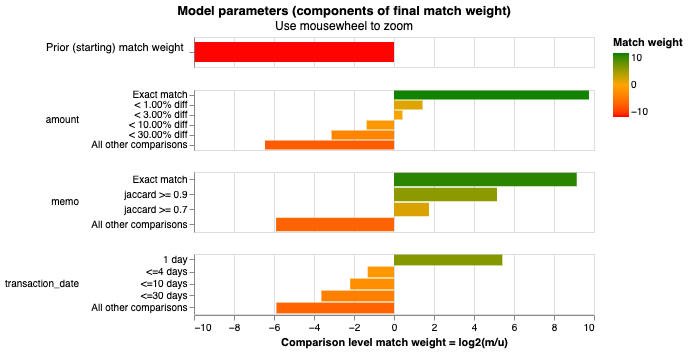

In [9]:
linker.match_weights_chart()

In [10]:
linker.estimate_parameters_using_expectation_maximisation("l.memo = r.memo")


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.memo = r.memo

Parameter estimates will be made for the following comparison(s):
    - amount
    - transaction_date

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - memo

Iteration 1: Largest change in params was -0.552 in the m_probability of amount, level `Exact match`
Iteration 2: Largest change in params was -0.217 in the m_probability of transaction_date, level `1 day`
Iteration 3: Largest change in params was 0.00821 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.00031 in the m_probability of transaction_date, level `<=30 days`
Iteration 5: Largest change in params was -0.000188 in the m_probability of amount, level `All other comparisons`
Iteration 6: Largest change in params was -0.000169 in the m_probability of amount, level `All other comparisons`
Iteration 7: Largest

<EMTrainingSession, blocking on l.memo = r.memo, deactivating comparisons memo>

In [11]:
session = linker.estimate_parameters_using_expectation_maximisation("l.amount = r.amount")


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.amount = r.amount

Parameter estimates will be made for the following comparison(s):
    - memo
    - transaction_date

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - amount

Iteration 1: Largest change in params was 0.491 in probability_two_random_records_match
Iteration 2: Largest change in params was 0.132 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.139 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.0295 in probability_two_random_records_match
Iteration 5: Largest change in params was 0.00399 in probability_two_random_records_match
Iteration 6: Largest change in params was 0.000531 in probability_two_random_records_match
Iteration 7: Largest change in params was 7.08e-05 in probability_two_random_records_match

EM converged after 7 ite

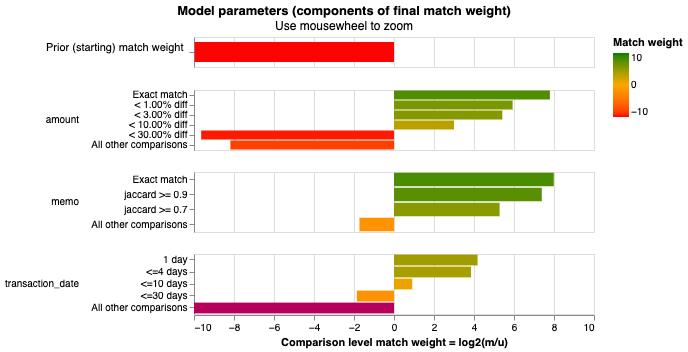

In [12]:
linker.match_weights_chart()

In [13]:
df_predict = linker.predict(threshold_match_probability=0.001)

In [14]:
df_predict.as_pandas_dataframe(limit=10)

,match_weight,match_probability,source_dataset_l,unique_id_l,source_dataset_r,unique_id_r,amount_l,amount_r,gamma_amount,bf_amount,memo_l,memo_r,gamma_memo,bf_memo,transaction_date_l,transaction_date_r,gamma_transaction_date,bf_transaction_date,match_key
0,7.287257,0.993639,__ori,0,_dest,0,36.36,36.36,5,222.034578,MATTHIAS C paym,MATTHIAS C payment BGC,1,38.832535,2022-03-28,2022-03-29,4,18.098060,0
1,-2.099078,0.189238,__ori,13,_dest,13,42.58,43.62,3,42.647939,M C payment,M C BGC,0,0.302099,2022-02-23,2022-02-24,4,18.098060,0
2,6.958328,0.992023,__ori,14,_dest,14,116.93,116.93,5,222.034578,M CORVINUS BGC,M CORVINUS,1,38.832535,2022-03-22,2022-03-24,3,14.408364,0
3,7.616606,0.994930,__ori,17,_dest,17,98.34,96.74,3,42.647939,M C money BGC,M C money BGC,3,254.016792,2022-05-03,2022-05-04,4,18.098060,0
4,7.287678,0.993641,__ori,18,_dest,18,38.23,39.02,3,42.647939,M C BGC,M C BGC,3,254.016792,2022-04-12,2022-04-14,3,14.408364,0
5,-4.841309,0.033708,__ori,31,_dest,31,81.34,77.57,2,8.006113,A F bcc9dd57 BG,A F BGC,0,0.302099,2022-04-20,2022-04-23,3,14.408364,0
6,7.287678,0.993641,__ori,33,_dest,33,174.32,172.06,3,42.647939,A F 22716847 BG,A F 22716847 BG,3,254.016792,2022-03-14,2022-03-16,3,14.408364,0
7,7.287678,0.993641,__ori,35,_dest,35,14073.09,14253.04,3,42.647939,ADRIANO F payme,ADRIANO F payme,3,254.016792,2022-02-07,2022-02-11,3,14.408364,0
8,7.616606,0.994930,__ori,36,_dest,36,1798.25,1823.28,3,42.647939,A F 8a6b4bb8 CH,A F 8a6b4bb8 CH,3,254.016792,2022-02-05,2022-02-06,4,18.098060,0
9,7.287678,0.993641,__ori,37,_dest,37,928.86,903.67,3,42.647939,A F 49c628c0 BG,A F 49c628c0 BG,3,254.016792,2022-05-04,2022-05-06,3,14.408364,0


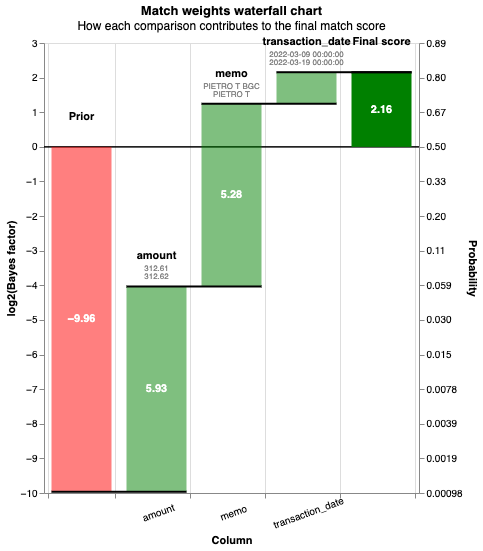

In [19]:
pred_errors =  linker.prediction_errors_from_label_column("ground_truth", include_false_positives=True, include_false_negatives=False)
linker.waterfall_chart(pred_errors.as_record_dict(limit=5))

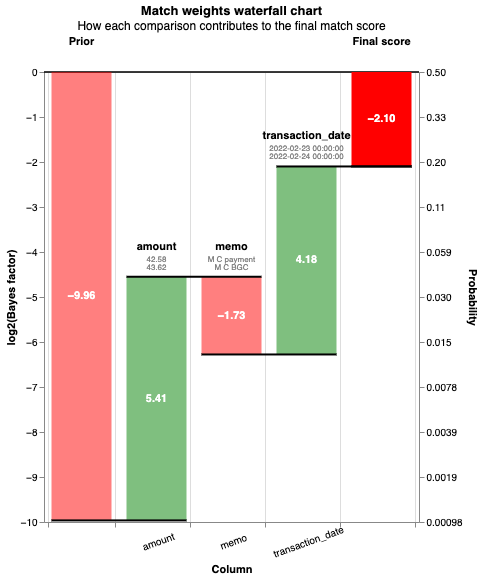

In [20]:
pred_errors =  linker.prediction_errors_from_label_column("ground_truth", include_false_positives=False, include_false_negatives=True)
linker.waterfall_chart(pred_errors.as_record_dict(limit=5))

In [22]:
linker.comparison_viewer_dashboard(df_predict,"comparison_viewer_transactions.html", overwrite=True)

In [23]:
from IPython.display import IFrame
IFrame(
    src="./comparison_viewer_transactions.html", width="100%", height=1200
)